## Things that should only have to be defined once, here at the top
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from lmfit import Model, Parameters
from lmfit.models import VoigtModel

# from scipy.stats import chisquare
# from scipy.integrate import trapz, simpson
# from scipy.optimize import curve_fit
# from scipy.signal import savgol_filter

from astropy.io import fits

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

c = 299792458  # speed of light m/s

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x, ampl, center, std):
    return ((ampl) / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - center) / std) ** 2)) + 1

# Reduced and order-merged data filepath 
# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('./standard_table_v2.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA

# mask for test spectra to check out the nonsense with sigma and such
test_mask = standard_table['Name'].isin(['HBC427','Hubble4','LkCa14'])

standard_table = standard_table[test_mask].reset_index(drop=True)

# early_k = ('1', '2', '3', '4', '5')
# Only want to look at the K types for the moment
# standard_table_k = standard_table[standard_table['Spectral_Type'].str.startswith(('K1', 'K2', 'K5'))]

standard_shift = standard_table['Wavelength Shift'].values
standard_list = standard_table['Source'].values

hops_table = pd.read_csv('./hops_table.txt')
hops_list = hops_table['Source']

# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(fits.getdata(file)[1]) for file in standard_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in standard_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in standard_list)

# Initialize stacks with NaN values
wavelen_stack = np.full((max_wavelen_length, len(standard_list)), np.nan)
raw_flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_list)), np.nan)
raw_flux_err_stack = np.full((max_snr_length, len(standard_list)), np.nan)

# Fill stacks with data
# Fill stacks with data
for i, file in enumerate(standard_list):
    # Get wavelength, flux, snr per resolution element data
    data = fits.getdata(file)
    wavelen, flux, snr = data[0], data[1], data[2] # type: ignore
    
    # Clean data a bit
    flux_min = 10000  # Minimum flux
    flux_cut = flux > flux_min  # Bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.4
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Calculate the error using raw_flux_err_stack
    flux_err = flux / snr
    
    # Now define the SNR cut using the raw_flux_err_stack
    snr_cut = (flux_err > 100)  # Example SNR cut

    # Apply masks and remove NaNs and infs
    mask = wavelen_cut & snr_cut
    
    wavelen = wavelen[mask]
    flux = flux[mask]
    flux_err = flux_err[mask]

    # Remove NaNs and infs from wavelen, flux, and flux_err arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isnan(flux) & ~np.isnan(flux_err)
    
    wavelen = wavelen[valid_indices]
    flux = flux[valid_indices]
    flux_err = flux_err[valid_indices]

    # Check for NaNs in the final arrays
    if np.any(np.isnan(wavelen)) or np.any(np.isnan(flux)) or np.any(np.isnan(flux_err)):
        print(f"NaNs found in data for file {file} after cleaning")

    # Update stacks with the cleaned data
    wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    raw_flux_stack[:len(flux), i] = flux  # savgol_filter(flux, window_length=11, polyorder=3)
    raw_flux_err_stack[:len(flux_err), i] = flux_err

# fig = plt.figure(figsize=(15,5))
# plt.errorbar(wavelen_stack[:,0], raw_flux_stack[:,0], raw_flux_err_stack[:,0])
# # plt.xlim(2.22,2.23)
# # plt.ylim(3.8e5,5e5)
# plt.show()

In [3]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I, Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

## Ti Region (+ Fe)

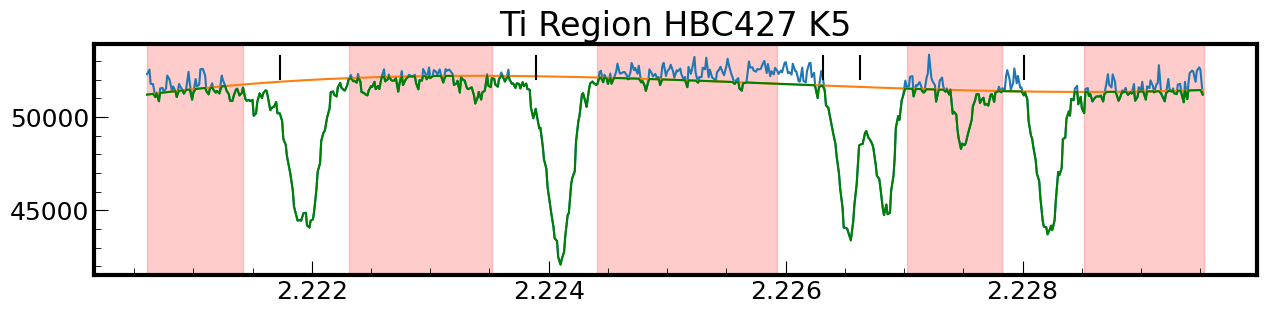

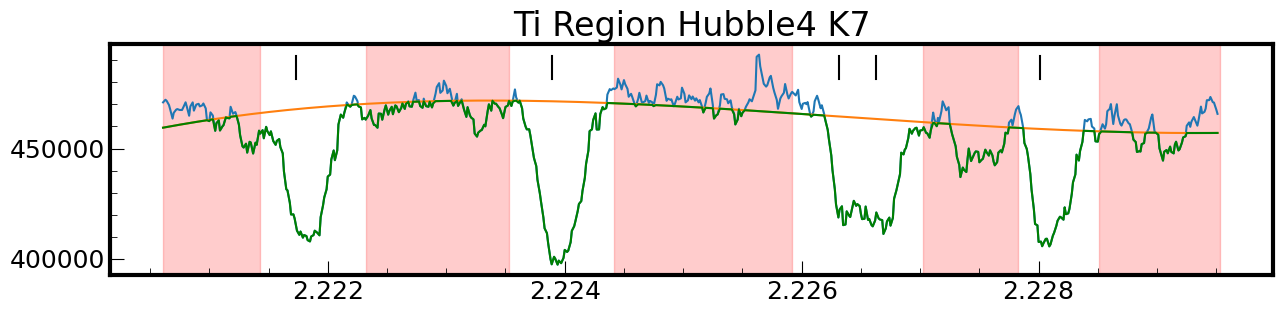

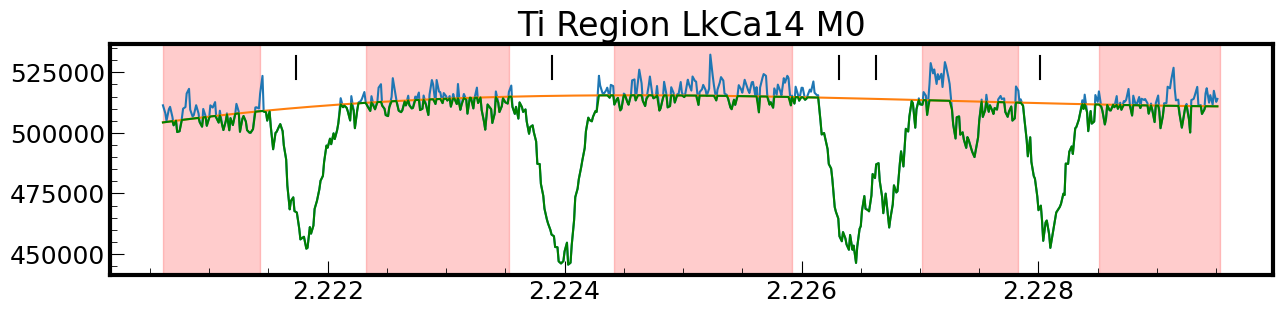

In [4]:
# Define the region for fitting
line_name = lines_table[fe1_mask][0]['Spectrum'] # Species
line_center = lines_table[fe1_mask][85]['Observed'] # Wavelength

# list of lab wavelengths
ti_reg_lines = np.array([lines_table[ti1_mask]['Observed'][44],
        lines_table[ti1_mask]['Observed'][45],
        lines_table[fe1_mask]['Observed'][85],
        lines_table[fe1_mask]['Observed'][86],
        lines_table[ti1_mask]['Observed'][47]])

# from igrins_mod import local_continuum_fit
continuum_stack = []
continuum_err_stack = []
norm_flux_stack = []
norm_flux_err_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-570,81),(-400,121),(-190,151), (70,81), (220,101)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table)):
    fig = plt.figure(figsize=(15,3))
    continuum, continuum_err, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    raw_flux_err_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # Adjust flux values above the continuum
    adjusted_flux = np.minimum(raw_flux_stack[region_indices[0][0]:region_indices[n][1],i], continuum)
    
    # Normalize flux by dividing the adjusted flux by the continuum
    norm_flux = adjusted_flux / continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    
    # Plot the adjusted flux
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], adjusted_flux, linestyle='-', color='green')
    
    for j in range(len(region_indices)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)
    for k in range(len(ti_reg_lines)):
        plt.axvline(ti_reg_lines[k], ymin=0.85, ymax=0.95, color='black')

    plt.title(f"Ti Region {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    plt.show()

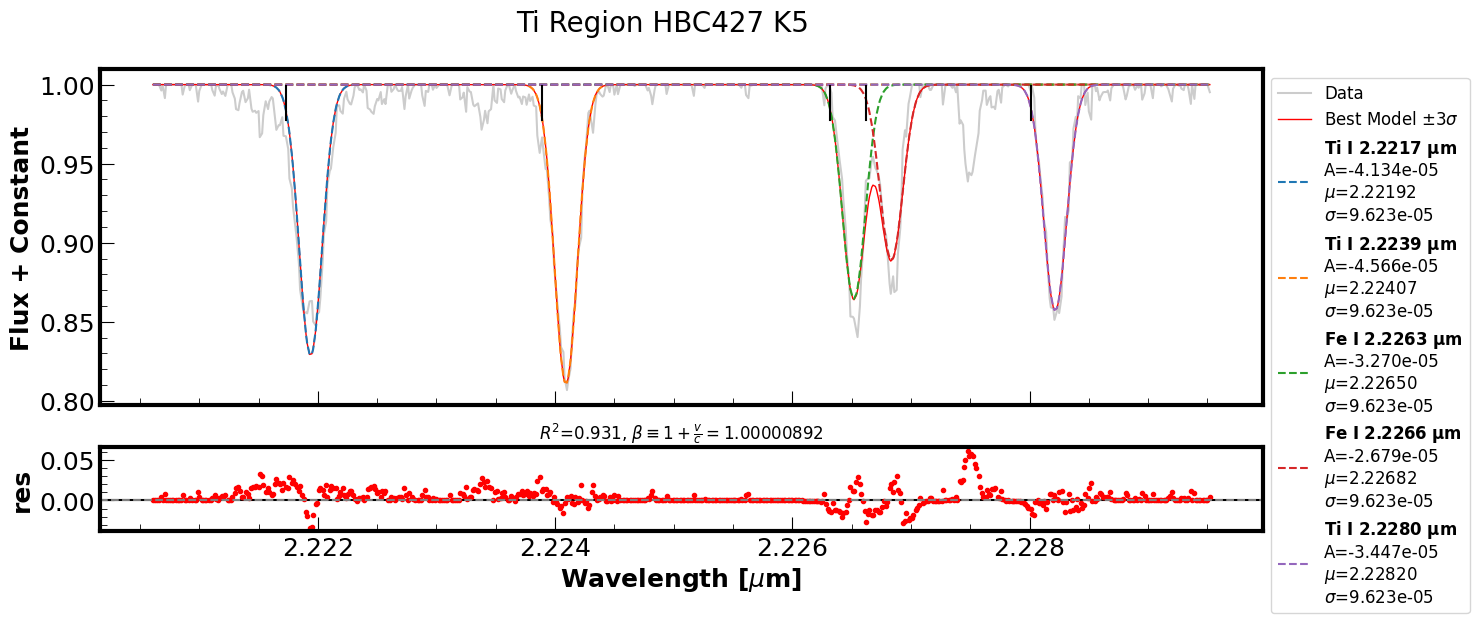

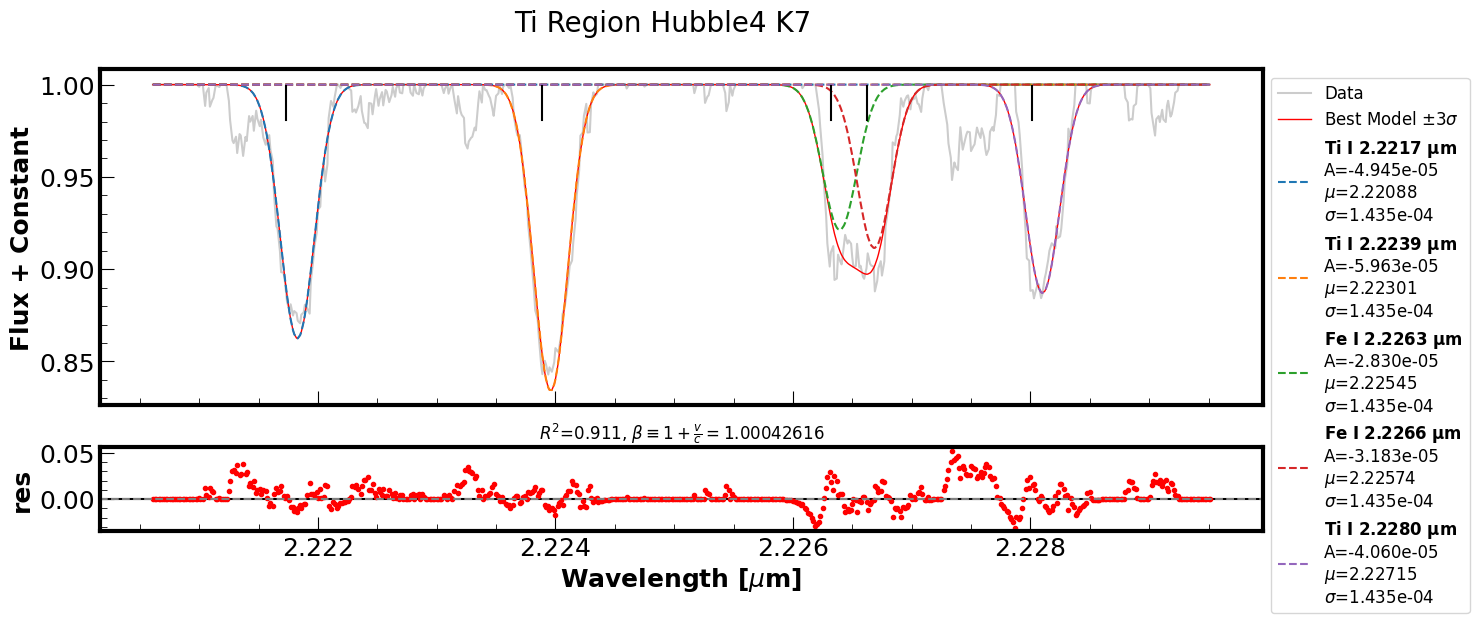

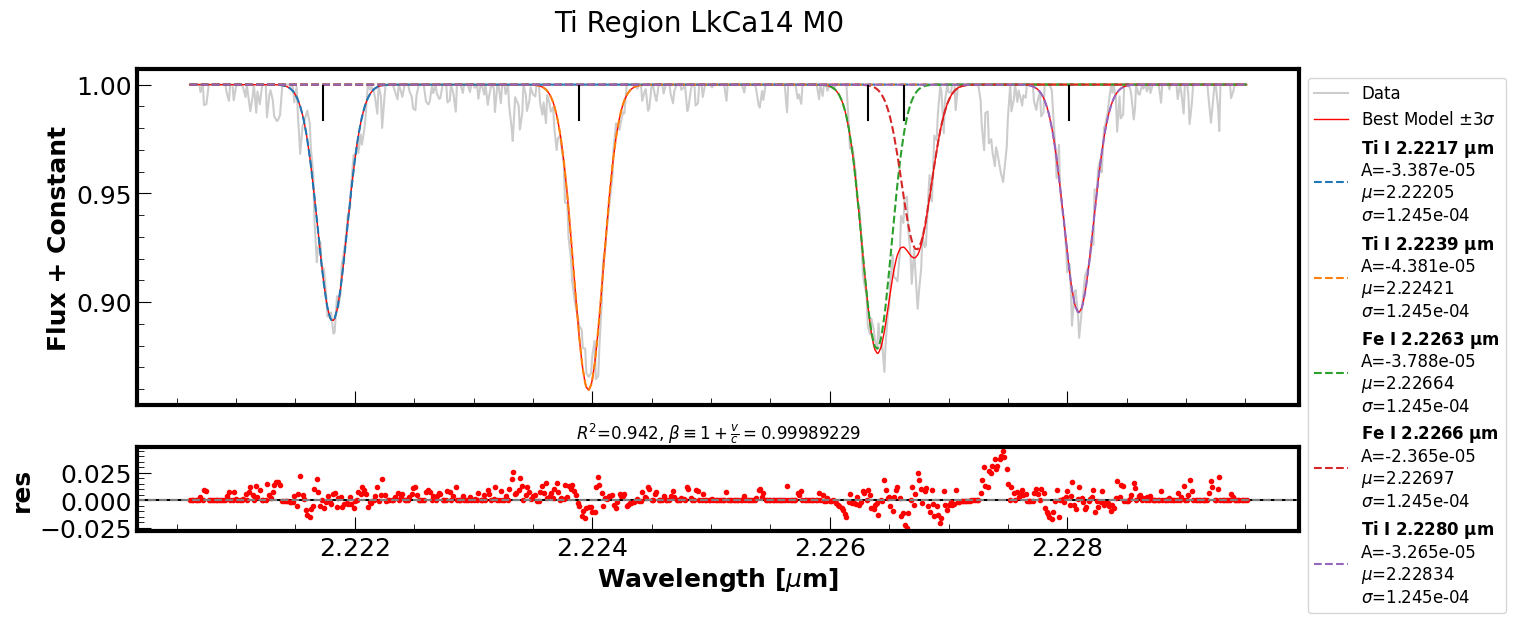

In [5]:
# Initialize storage lists
params_stack = []
beta_stack = []
params_error_stack = []
best_model_stack = []
result_stack = []
dely_stack = []

mean_sigma_stack = []

for i in range(len(standard_table)):
    # Define initial parameters for Gaussian fitting
    params = Parameters()

    params.add('amp1', value = 1e-5, max = 0)
    params.add('c1', value = ti_reg_lines[0])
    params.add('std1', value = spec_res)

    params.add('amp2', value = 1e-5, max = 0)
    params.add('c2', value = ti_reg_lines[1])
    # params.add('std2', value = spec_res)

    params.add('amp3', value = 1e-5, max = 0)
    params.add('c3', value = ti_reg_lines[2])
    # params.add('std3', value = spec_res)

    params.add('amp4', value = 1e-5, max = 0)
    params.add('c4', value = ti_reg_lines[3])
    # params.add('std4', value = spec_res)

    params.add('amp5', value = 1e-5, max = 0)
    params.add('c5', value = ti_reg_lines[4])
    # params.add('std5', value = spec_res)

    params.add('beta', value=1)

    # Define Model
    model = Model(ig.five_gaussian_beta, nan_policy='omit')

    result = model.fit(norm_flux_stack[i], params,
                       x = wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])
                       #weights = 1/raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])

    result_stack.append(result) # list of lmfit ModelResult objects
    dely = result.eval_uncertainty(sigma=3) # lmfit uncertainties
    dely_stack.append(dely) # stack of errors for each source

    # Append the best_model, error and parameters stacks
    # could probably make a loop to the tune of for value in result etc...
    params_stack.extend([result.params['amp1'].value, result.params['c1'].value, result.params['std1'].value,
                         result.params['amp2'].value, result.params['c2'].value, result.params['std1'].value,
                         result.params['amp3'].value, result.params['c3'].value, result.params['std1'].value,
                         result.params['amp4'].value, result.params['c4'].value, result.params['std1'].value,
                         result.params['amp5'].value, result.params['c5'].value, result.params['std1'].value])
    beta_stack.append(result.params['beta'].value)
    
    params_error_stack.extend([result.params['amp1'].stderr, result.params['c1'].stderr, result.params['std1'].stderr,
                               result.params['amp2'].stderr, result.params['c2'].stderr, result.params['std1'].stderr,
                               result.params['amp3'].stderr, result.params['c3'].stderr, result.params['std1'].stderr,
                               result.params['amp4'].stderr, result.params['c4'].stderr, result.params['std1'].stderr,
                               result.params['amp5'].stderr, result.params['c5'].stderr, result.params['std1'].stderr])

    best_model_stack.append(result.best_fit)

params_arr = np.array(params_stack)

amps = params_arr[0::3]
amps_err = params_error_stack[0::3]

centers = params_arr[1::3]
center_err = params_error_stack[1::3]

sigmas = params_arr[2::3]
sigmas_err = params_error_stack[2::3]

ti1_2_2217_fits = []
ti1_2_2239_fits = []
fe1_2_2263_fits = [] # maybe fix wavelength offsets
fe1_2_2266_fits = []
ti1_2_2280_fits = []
num_gauss = 5

for i in range(len(standard_table)):
    ti1_2_2217_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[0::num_gauss][i],centers[0::num_gauss][i]*beta_stack[i],sigmas[0::num_gauss][i]))

    ti1_2_2239_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[1::num_gauss][i],centers[1::num_gauss][i]*beta_stack[i],sigmas[1::num_gauss][i]))

    fe1_2_2263_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[2::num_gauss][i],centers[2::num_gauss][i]*beta_stack[i],sigmas[2::num_gauss][i]))

    fe1_2_2266_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[3::num_gauss][i],centers[3::num_gauss][i]*beta_stack[i],sigmas[3::num_gauss][i]))

    ti1_2_2280_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[4::num_gauss][i],centers[4::num_gauss][i]*beta_stack[i],sigmas[4::num_gauss][i]))
    

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table)):
    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], alpha=0.2, c='black', label='Data')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i], c='red', lw=1, label=r'Best Model $\pm 3 \sigma$ ')
    # ax1.errorbar(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i],yerr=dely_stack[i], c='red', lw=1, label='Best Model')
    # ax1.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
    #                  best_model_stack[i]-dely_stack[i], best_model_stack[i]+dely_stack[i],
    #                  alpha=0.2, color='red')
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],ti1_2_2217_fits[i], ls='--',
        label = r'$\bf{Ti~I~2.2217~\mu m}$' '\n' rf'A={amps[0::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[0::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[0::num_gauss][i]:.3e}')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],ti1_2_2239_fits[i], ls='--',
        label = r'$\bf{Ti~I~2.2239~\mu m}$' '\n' rf'A={amps[1::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[1::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[1::num_gauss][i]:.3e}')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_2263_fits[i], ls='--',
        label = r'$\bf{Fe~I~2.2263~\mu m}$' '\n' rf'A={amps[2::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[2::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[2::num_gauss][i]:.3e}')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_2266_fits[i], ls='--',
        label = r'$\bf{Fe~I~2.2266~\mu m}$' '\n' rf'A={amps[3::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[3::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[3::num_gauss][i]:.3e}')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],ti1_2_2280_fits[i], ls='--',
        label = r'$\bf{Ti~I~2.2280~\mu m}$' '\n' rf'A={amps[4::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[4::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[4::num_gauss][i]:.3e}')

    for j in range(len(ti_reg_lines)):
        ax1.axvline(ti_reg_lines[j], ymin=0.85, ymax=0.95, color='black')
    
    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1,1), fontsize=12)

    # Calculate residuals
    residuals = (norm_flux_stack[i] - best_model_stack[i])
    sqsum_res = np.sum(residuals**2)
    sqsum = np.sum(norm_flux_stack[i]-np.mean(norm_flux_stack[i])**2) # sum(data - mean(data)^2)
    R2 = 1-(sqsum_res/sqsum) # R^2 statistic

    # Plot residuals
    # ax2.scatter(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals', s=3)
    result_stack[i].plot_residuals(ax=ax2, datafmt='r.')
    ax2.axhline(y=0, color='grey', linestyle='--')
    # ax2.set_ylim(-0.1,0.1)
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax2.set_ylabel('res')
    ax2.set_title(rf"$R^2$={result_stack[i].rsquared:.3f}, " r'$\beta \equiv 1+\frac{v}{c}= $' f"{beta_stack[i]:.8f}", fontsize=12)
    
    plt.suptitle(rf"Ti Region {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    plt.show()

In [6]:
delt_diff_stack = []
ref_line = 0 # reference spectral feature index

for i in range(len(standard_table)):
    # To store the differences for each spectrum
    delta_diff_spectrum = []
    for j in range(len(ti_reg_lines)):
        # fit line center and ref line center offset
        fit_ref_diff = np.abs(centers[j::num_gauss][i] - centers[ref_line::num_gauss][i])
        # print(fit_ref_diff)
        # lab line center and ref line center offset
        lab_ref_diff = np.abs(ti_reg_lines - ti_reg_lines[ref_line])[j]
        # print(lab_ref_diff)
        # difference between the delta wavelengths
        delta_diff = np.abs(fit_ref_diff - lab_ref_diff)
        # print(delta_diff)
        # append to list of differences for spectrum i
        delta_diff_spectrum.append(delta_diff)
        
    # append the differences for this spectrum to the main list
    delt_diff_stack.append(delta_diff_spectrum)
print(delt_diff_stack)

[[0.0, 8.649701179752611e-06, 8.93282211622548e-06, 1.6395048652029232e-07, 4.384047337158137e-06], [0.0, 2.8256062553744243e-05, 2.317497601245222e-05, 3.993797208279304e-05, 9.540132036800486e-06], [0.0, 5.812702932317393e-06, 4.736766866741959e-06, 2.384081372230895e-05, 3.479361434077788e-06]]


In [7]:
line_center_arr = np.empty(shape=(len(standard_table),len(ti_reg_lines)))
for i in range(len(standard_table)):
    line_center_arr[i] = (ti_reg_lines + delt_diff_stack[i])

ti_reg_tweak = np.empty(shape=(len(ti_reg_lines)))

for j in range(len(ti_reg_lines)):
    # take the average value for each line and create a new list of line centers
    ti_reg_tweak[j] = np.mean(line_center_arr[:,j])

print("Tweaked Wavelength Array:", line_center_arr)
print("avg:", ti_reg_tweak)

Tweaked Wavelength Array: [[2.221729   2.22389865 2.22632693 2.22662546 2.22801538]
 [2.221729   2.22391826 2.22634117 2.22666524 2.22802054]
 [2.221729   2.22389581 2.22632274 2.22664914 2.22801448]]
avg: [2.221729   2.22390424 2.22633028 2.22664661 2.2280168 ]


Offset from tweaked lab wavelength to fit center for line 1: 0.00000e+00
Offset from tweaked lab wavelength to fit center for line 2: 1.42395e-05
Offset from tweaked lab wavelength to fit center for line 3: 1.22815e-05
Offset from tweaked lab wavelength to fit center for line 4: 2.13142e-05
Offset from tweaked lab wavelength to fit center for line 5: 5.80118e-06


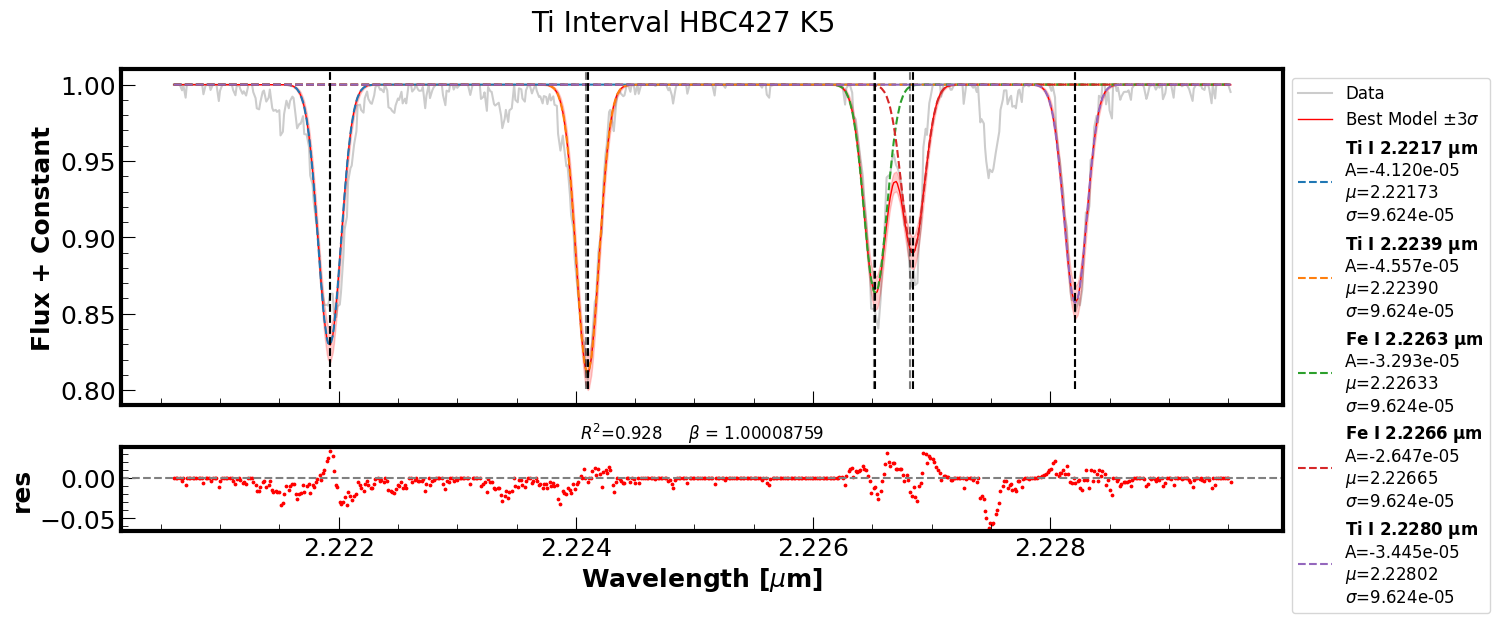

Offset from tweaked lab wavelength to fit center for line 1: 0.00000e+00
Offset from tweaked lab wavelength to fit center for line 2: 1.42395e-05
Offset from tweaked lab wavelength to fit center for line 3: 1.22815e-05
Offset from tweaked lab wavelength to fit center for line 4: 2.13142e-05
Offset from tweaked lab wavelength to fit center for line 5: 5.80118e-06


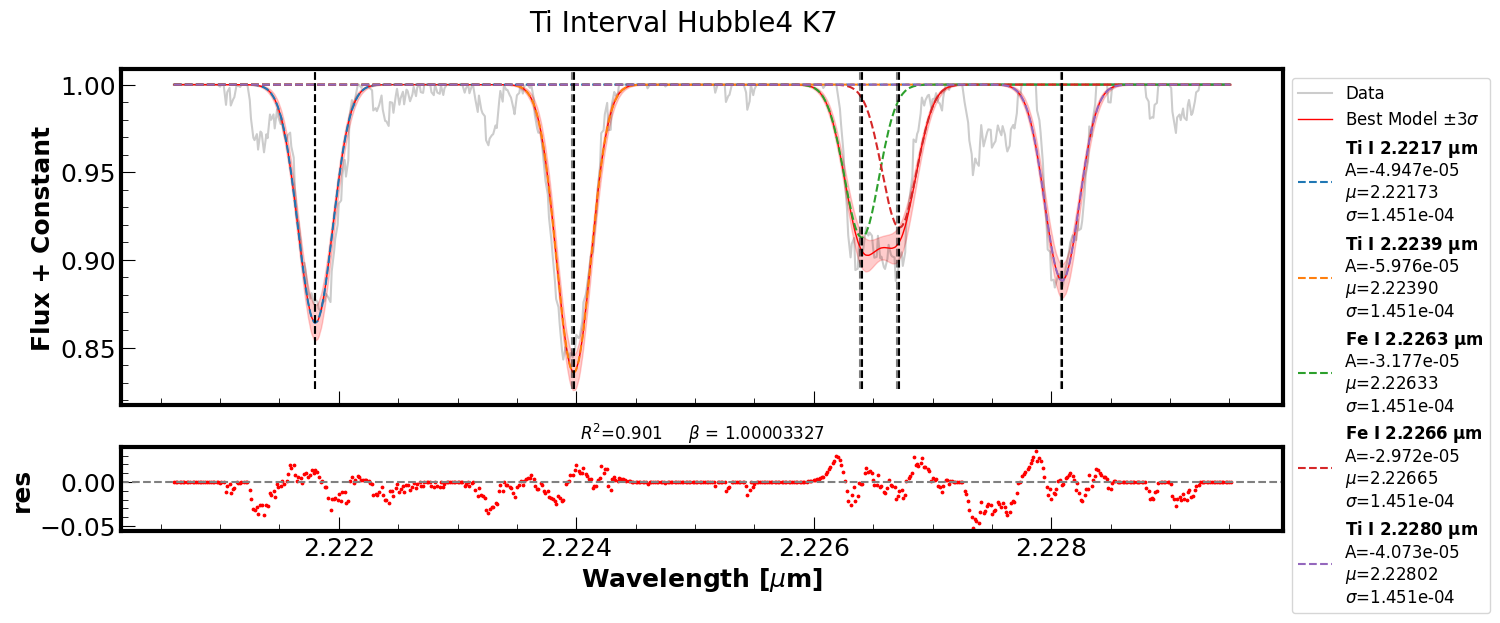

Offset from tweaked lab wavelength to fit center for line 1: 0.00000e+00
Offset from tweaked lab wavelength to fit center for line 2: 1.42395e-05
Offset from tweaked lab wavelength to fit center for line 3: 1.22815e-05
Offset from tweaked lab wavelength to fit center for line 4: 2.13142e-05
Offset from tweaked lab wavelength to fit center for line 5: 5.80118e-06


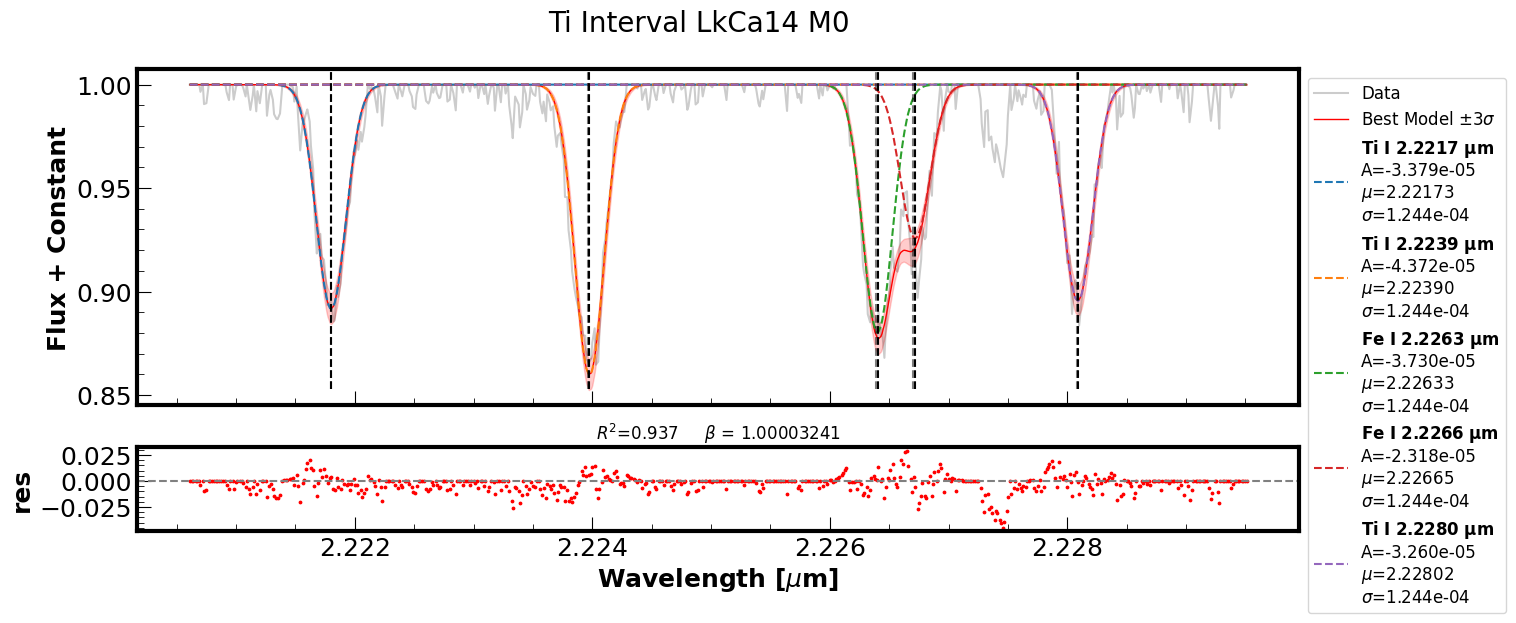

In [8]:
# Initialize storage lists
params_stack = []
beta_stack = []
params_error_stack = []
best_model_stack = []
result_stack = []
dely_stack = []

mean_sigma_stack = []

for i in range(len(standard_table)):    
    # Define initial parameters for Gaussian fitting
    params = Parameters()

    params.add('amp1', value = 1e-5, max = 0)
    params.add('c1', value = ti_reg_lines[0])
    params.add('std1', value = spec_res)

    params.add('amp2', value = 1e-5, max = 0)
    params.add('c2', value = ti_reg_lines[1])
    # params.add('std2', value = spec_res)

    params.add('amp3', value = 1e-5, max = 0)
    params.add('c3', value = ti_reg_lines[2])
    # params.add('std3', value = spec_res)

    params.add('amp4', value = 1e-5, max = 0)
    params.add('c4', value = ti_reg_lines[3])
    # params.add('std4', value = spec_res)

    params.add('amp5', value = 1e-5, max = 0)
    params.add('c5', value = ti_reg_lines[4])
    # params.add('std5', value = spec_res)

    params.add('beta', value=1)

    # tweak lab wavelengths
    params['c1'].expr = f'{ti_reg_tweak[0]}'
    params['c2'].expr = f'{ti_reg_tweak[1]}'
    params['c3'].expr = f'{ti_reg_tweak[2]}'
    params['c4'].expr = f'{ti_reg_tweak[3]}'
    params['c5'].expr = f'{ti_reg_tweak[4]}'

    # Define Model
    model = Model(ig.five_gaussian_beta, nan_policy='omit')

    result = model.fit(norm_flux_stack[i], params,
                       x = wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])
                       #weights = 1/raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])

    result_stack.append(result) # list of lmfit ModelResult objects
    dely = result.eval_uncertainty(sigma=3) # lmfit uncertainties
    dely_stack.append(dely) # stack of errors for each source

    # Append the best_model, error and parameters stacks
    # could probably make a loop to the tune of for value in result etc...
    params_stack.extend([result.params['amp1'].value, result.params['c1'].value, result.params['std1'].value,
                         result.params['amp2'].value, result.params['c2'].value, result.params['std1'].value,
                         result.params['amp3'].value, result.params['c3'].value, result.params['std1'].value,
                         result.params['amp4'].value, result.params['c4'].value, result.params['std1'].value,
                         result.params['amp5'].value, result.params['c5'].value, result.params['std1'].value])
    beta_stack.append(result.params['beta'].value)
    
    params_error_stack.extend([result.params['amp1'].stderr, result.params['c1'].stderr, result.params['std1'].stderr,
                               result.params['amp2'].stderr, result.params['c2'].stderr, result.params['std1'].stderr,
                               result.params['amp3'].stderr, result.params['c3'].stderr, result.params['std1'].stderr,
                               result.params['amp4'].stderr, result.params['c4'].stderr, result.params['std1'].stderr,
                               result.params['amp5'].stderr, result.params['c5'].stderr, result.params['std1'].stderr])

    best_model_stack.append(result.best_fit)

params_arr = np.array(params_stack)

amps = params_arr[0::3]
amps_err = params_error_stack[0::3]

centers = params_arr[1::3]
center_err = params_error_stack[1::3]

sigmas = params_arr[2::3]
sigmas_err = params_error_stack[2::3]

ti1_2_2217_fits = []
ti1_2_2239_fits = []
fe1_2_2263_fits = [] # maybe fix wavelength offsets
fe1_2_2266_fits = []
ti1_2_2280_fits = []
num_gauss = 5

for i in range(len(standard_table)):
    ti1_2_2217_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[0::num_gauss][i],centers[0::num_gauss][i]*beta_stack[i],sigmas[0::num_gauss][i]))

    ti1_2_2239_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[1::num_gauss][i],centers[1::num_gauss][i]*beta_stack[i],sigmas[1::num_gauss][i]))

    fe1_2_2263_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[2::num_gauss][i],centers[2::num_gauss][i]*beta_stack[i],sigmas[2::num_gauss][i]))

    fe1_2_2266_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[3::num_gauss][i],centers[3::num_gauss][i]*beta_stack[i],sigmas[3::num_gauss][i]))

    ti1_2_2280_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
        amps[4::num_gauss][i],centers[4::num_gauss][i]*beta_stack[i],sigmas[4::num_gauss][i]))
    

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table)):
    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], alpha=0.2, c='black', label='Data')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i], c='red', lw=1, label=r'Best Model $\pm 3 \sigma$ ')
    # ax1.errorbar(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i],yerr=dely_stack[i], c='red', lw=1, label='Best Model')
    ax1.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                     best_model_stack[i]-dely_stack[i], best_model_stack[i]+dely_stack[i],
                     alpha=0.2, color='red')
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],ti1_2_2217_fits[i], ls='--',
        label = r'$\bf{Ti~I~2.2217~\mu m}$' '\n' rf'A={amps[0::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[0::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[0::num_gauss][i]:.3e}')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],ti1_2_2239_fits[i], ls='--',
        label = r'$\bf{Ti~I~2.2239~\mu m}$' '\n' rf'A={amps[1::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[1::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[1::num_gauss][i]:.3e}')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_2263_fits[i], ls='--',
        label = r'$\bf{Fe~I~2.2263~\mu m}$' '\n' rf'A={amps[2::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[2::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[2::num_gauss][i]:.3e}')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_2266_fits[i], ls='--',
        label = r'$\bf{Fe~I~2.2266~\mu m}$' '\n' rf'A={amps[3::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[3::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[3::num_gauss][i]:.3e}')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],ti1_2_2280_fits[i], ls='--',
        label = r'$\bf{Ti~I~2.2280~\mu m}$' '\n' rf'A={amps[4::num_gauss][i]:.3e}' '\n' rf'$\mu$={centers[4::num_gauss][i]:.5f}' '\n' rf'$\sigma$={sigmas[4::num_gauss][i]:.3e}')

 
    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1,1), fontsize=12)

    for j in range(len(ti_reg_lines)):
        ax1.axvline(ti_reg_lines[j]*beta_stack[i], ymin=0.05, ymax=1., color='black', ls='--', alpha=0.5)
        ax1.axvline(ti_reg_tweak[j]*beta_stack[i], ymin=0.05, ymax=1., color='black', ls='--')
        print(f"Offset from tweaked lab wavelength to fit center for line {j+1}: {np.abs(ti_reg_lines[j]-(ti_reg_tweak[j])):.5e}")

    # Calculate residuals
    residuals = (norm_flux_stack[i] - best_model_stack[i])
    sqsum_res = np.sum(residuals**2)
    sqsum = np.sum(norm_flux_stack[i]-np.mean(norm_flux_stack[i])**2) # sum(data - mean(data)^2)
    R2 = 1-(sqsum_res/sqsum) # R^2 statistic

    # Plot residuals
    ax2.scatter(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals', s=3)
    ax2.axhline(y=0, color='grey', linestyle='--')
    # ax2.set_ylim(-0.1,0.1)
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax2.set_ylabel('res')
    ax2.set_title(rf'$R^2$={result_stack[i].rsquared:.3f} $\quad$ $\beta$ = {beta_stack[i]:.8f}', fontsize=12)

    plt.suptitle(rf"Ti Interval {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    plt.show()

In [12]:
print(np.abs(ti_reg_lines-ti_reg_tweak))

[0.00000000e+00 1.38370971e-05 1.12005938e-05 2.06091212e-05
 3.95537694e-06]
